## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

## **Reading Labels**

In [12]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'E:/IBM_Hack/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

## **Merging Data**

In [14]:
def read_merge_data(house):
    path = 'E:/IBM_Hack/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
   
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))//2
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    print(df.values[0])
#     f= open('E:/redd/low_freq_rect/house_{}/'.format(house)+'channel_{}'.format(house)+'.dat','a+') 
#     f.write(df.to_string())
#     f.close()
    return df
df = {}
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_rows',-1)
for i in range(1,7):
    df[i] = read_merge_data(i)

[222.2  118.83   0.     0.     6.     0.    34.    21.    81.     0.
   5.     1.     0.     0.     2.     0.    65.    46.     0.     0.  ]
[15.71 22.61  1.    8.    1.    4.    4.    4.    6.    1.    0.  ]
[181.34 577.3    2.     0.     1.   126.   119.     0.     0.     5.
 180.    27.     0.     0.     1.     2.   195.     2.    23.     0.
   0.     0.  ]
[462.31  86.58 243.     4.     1.     0.     0.     5.     0.     0.
   2.     0.    51.   139.     0.     0.     0.    15.     0.     0.  ]
[115.74 196.83   4.     0.     4.     6.     1.     0.     0.    12.5
   7.5    0.     0.     3.     0.     1.     0.   158.     1.     1.
   0.     7.5   67.5    0.     0.     0.  ]
[ 46.78 255.62   5.     2.     3.     0.     3.     1.     0.     0.
  26.    88.     0.   124.     4.     0.     0.  ]


In [15]:
dates = {}
for i in range(1,7):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

## **Plotting the Data**

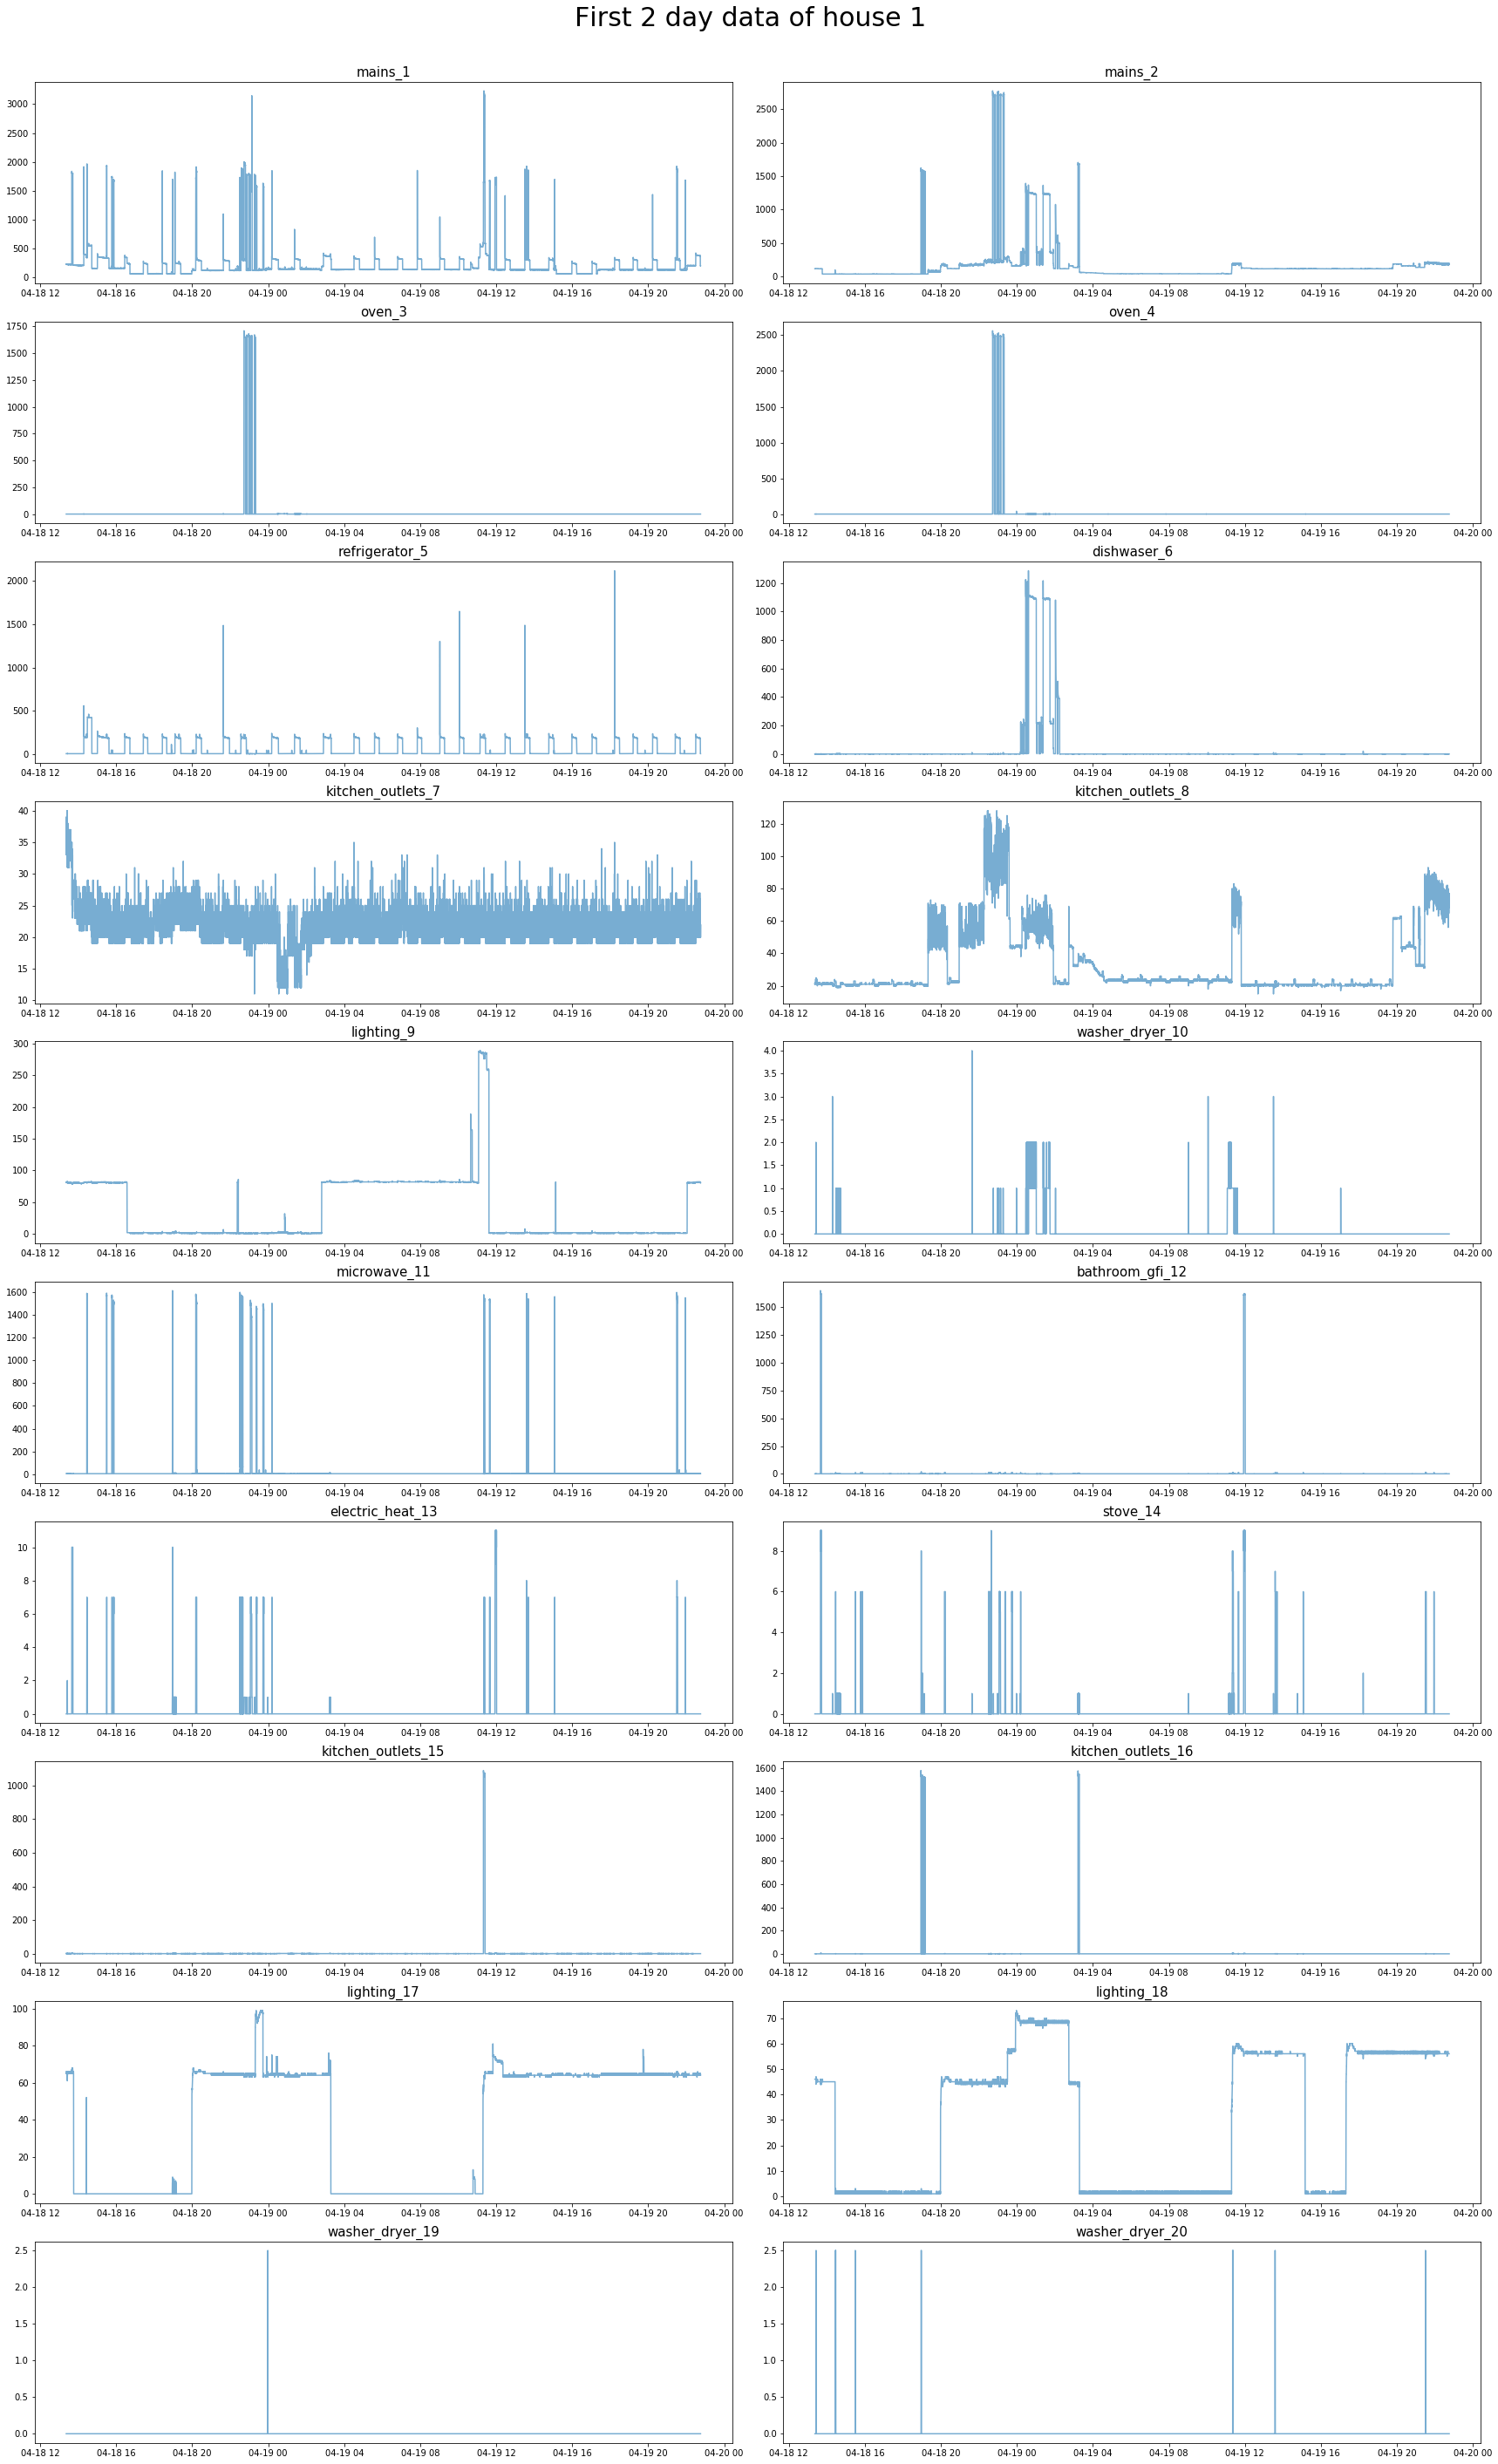

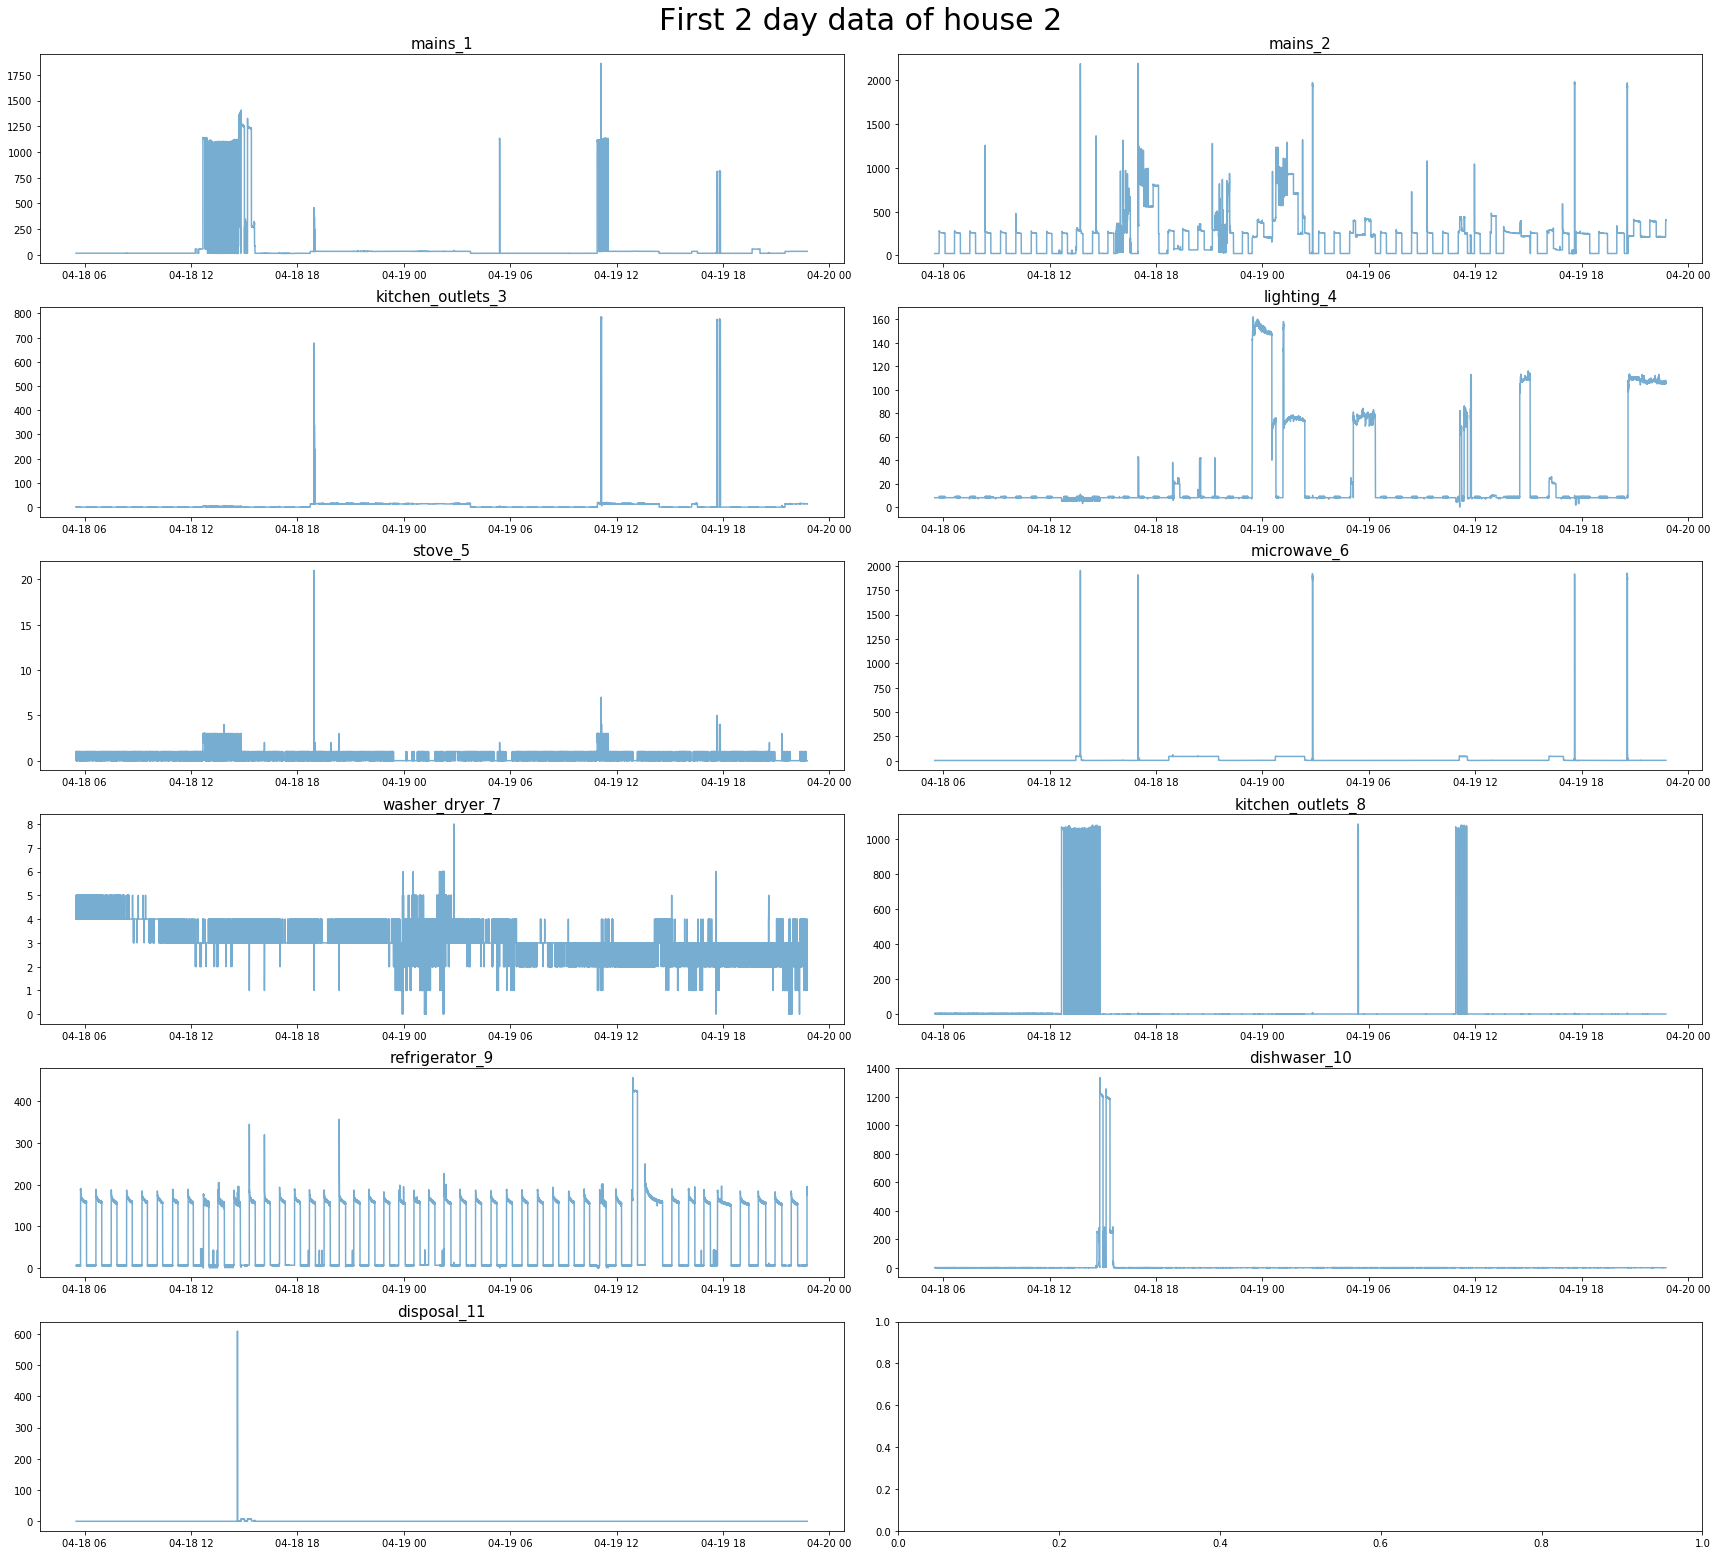

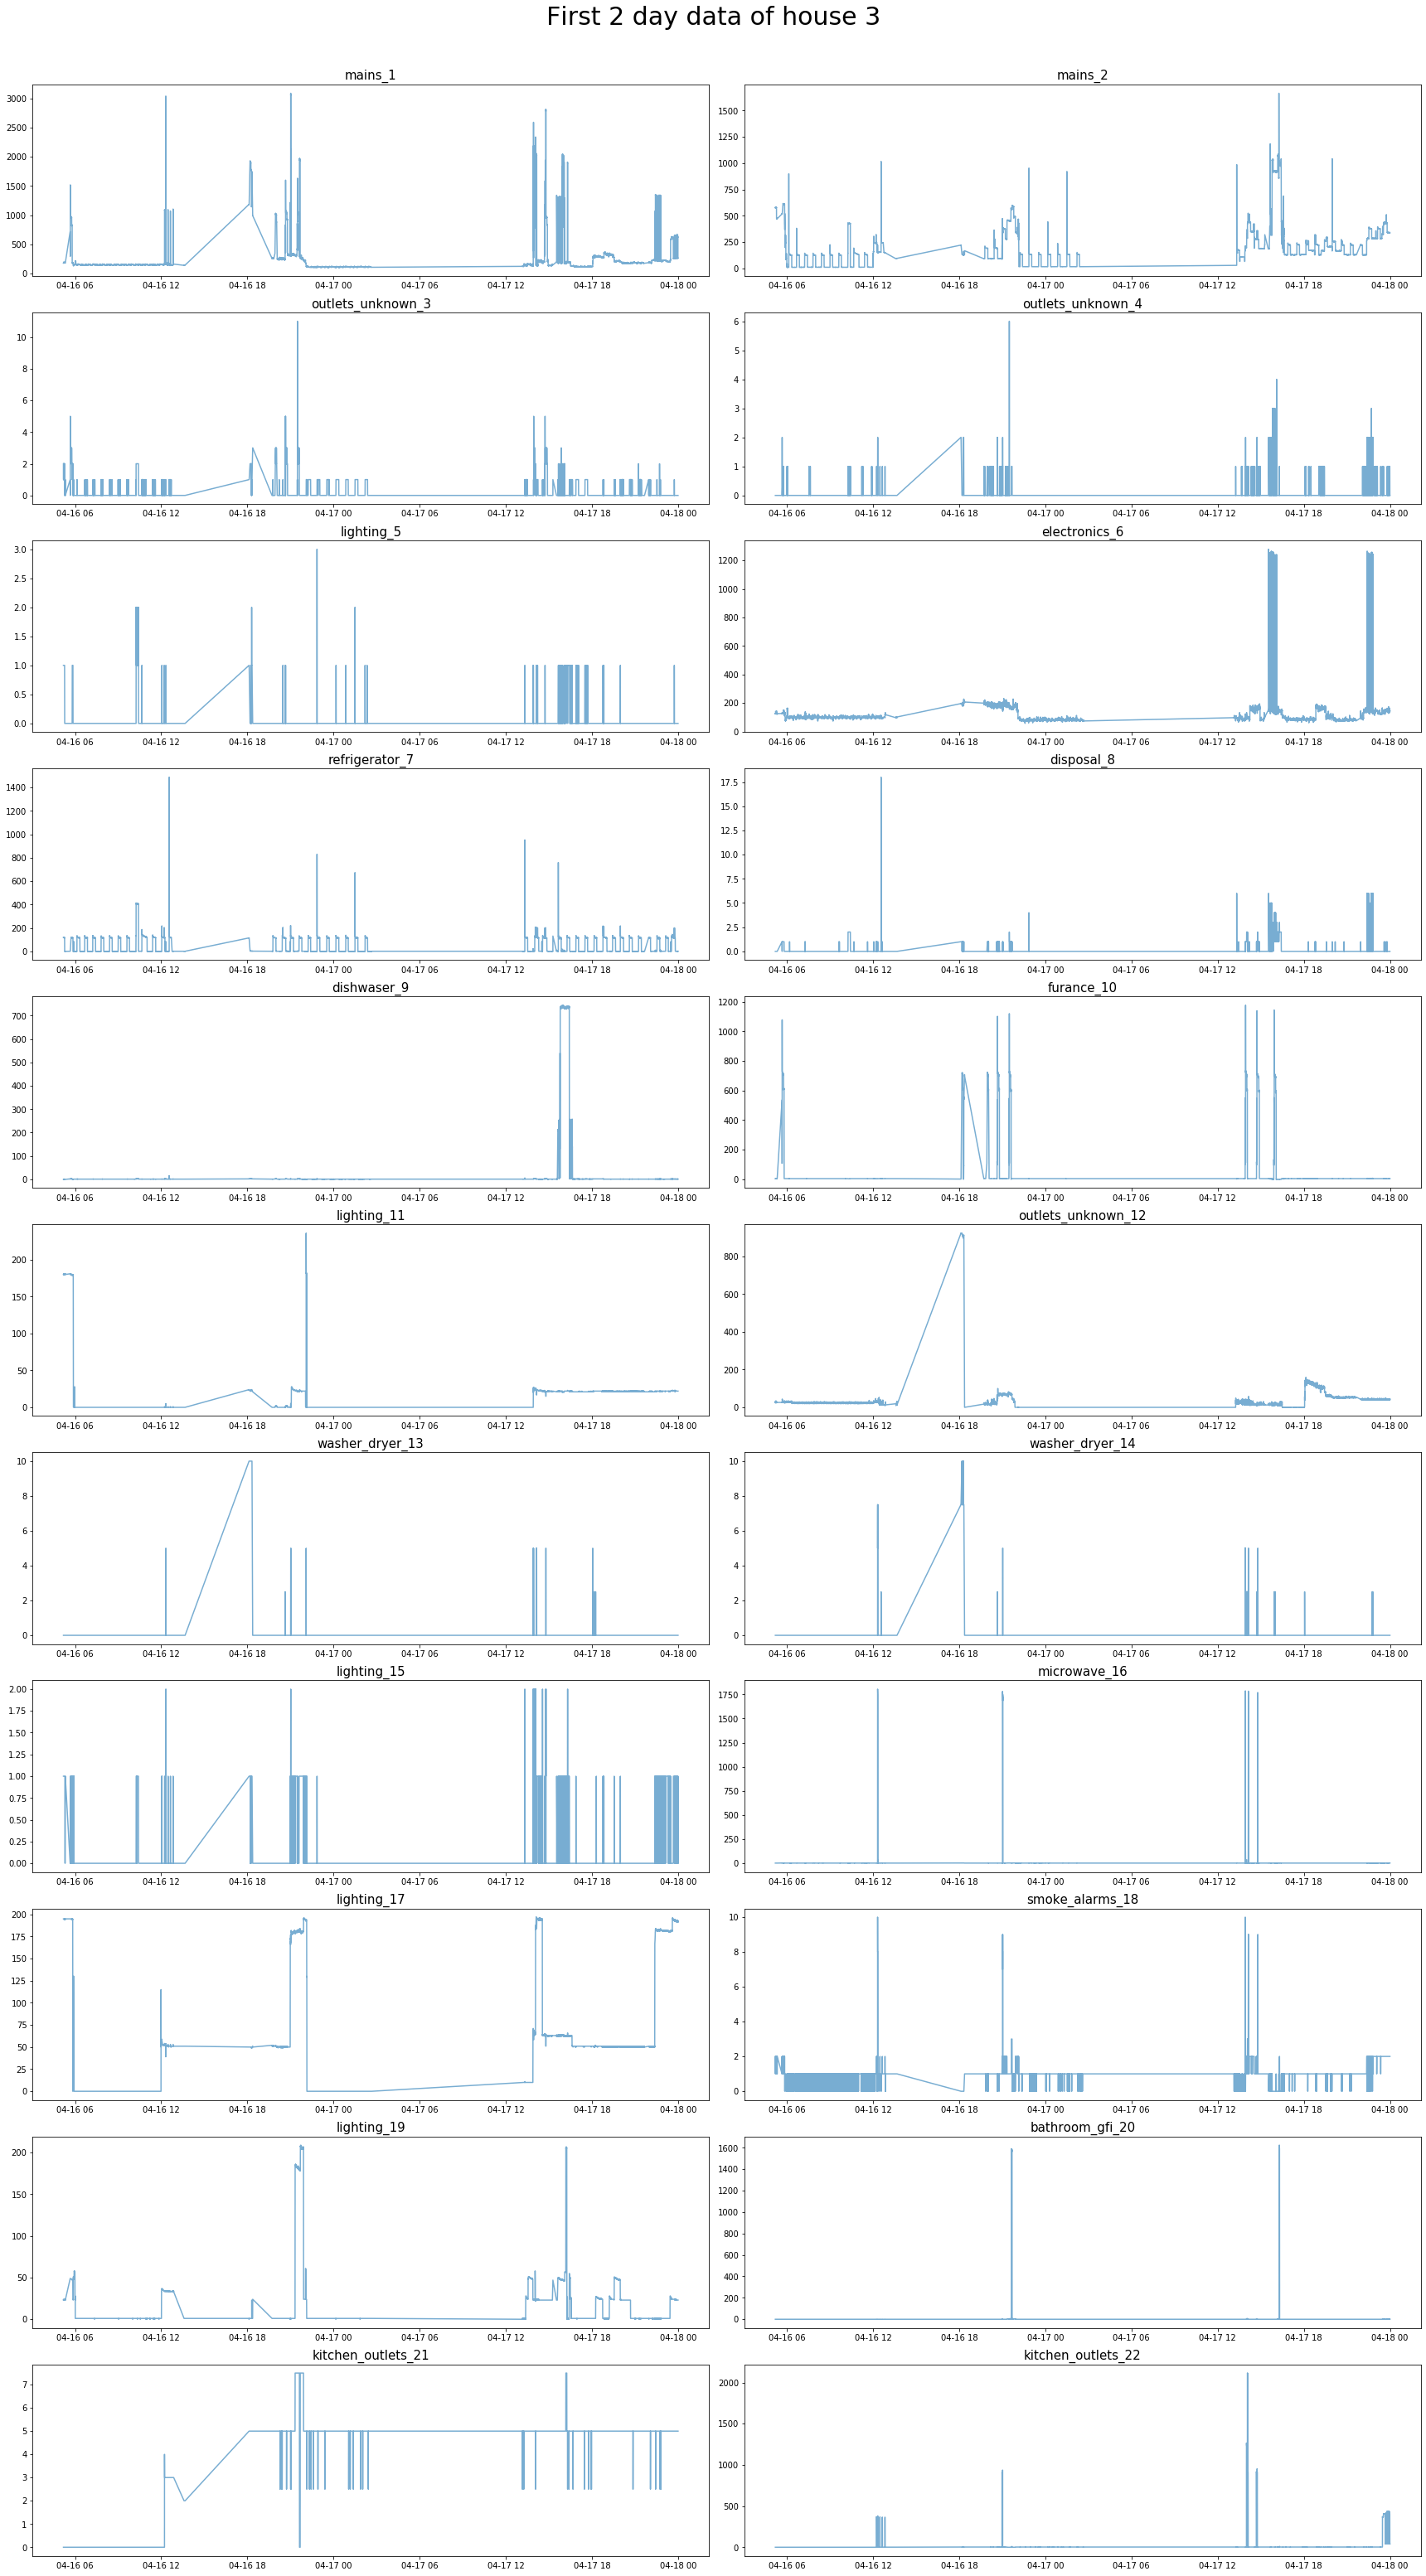

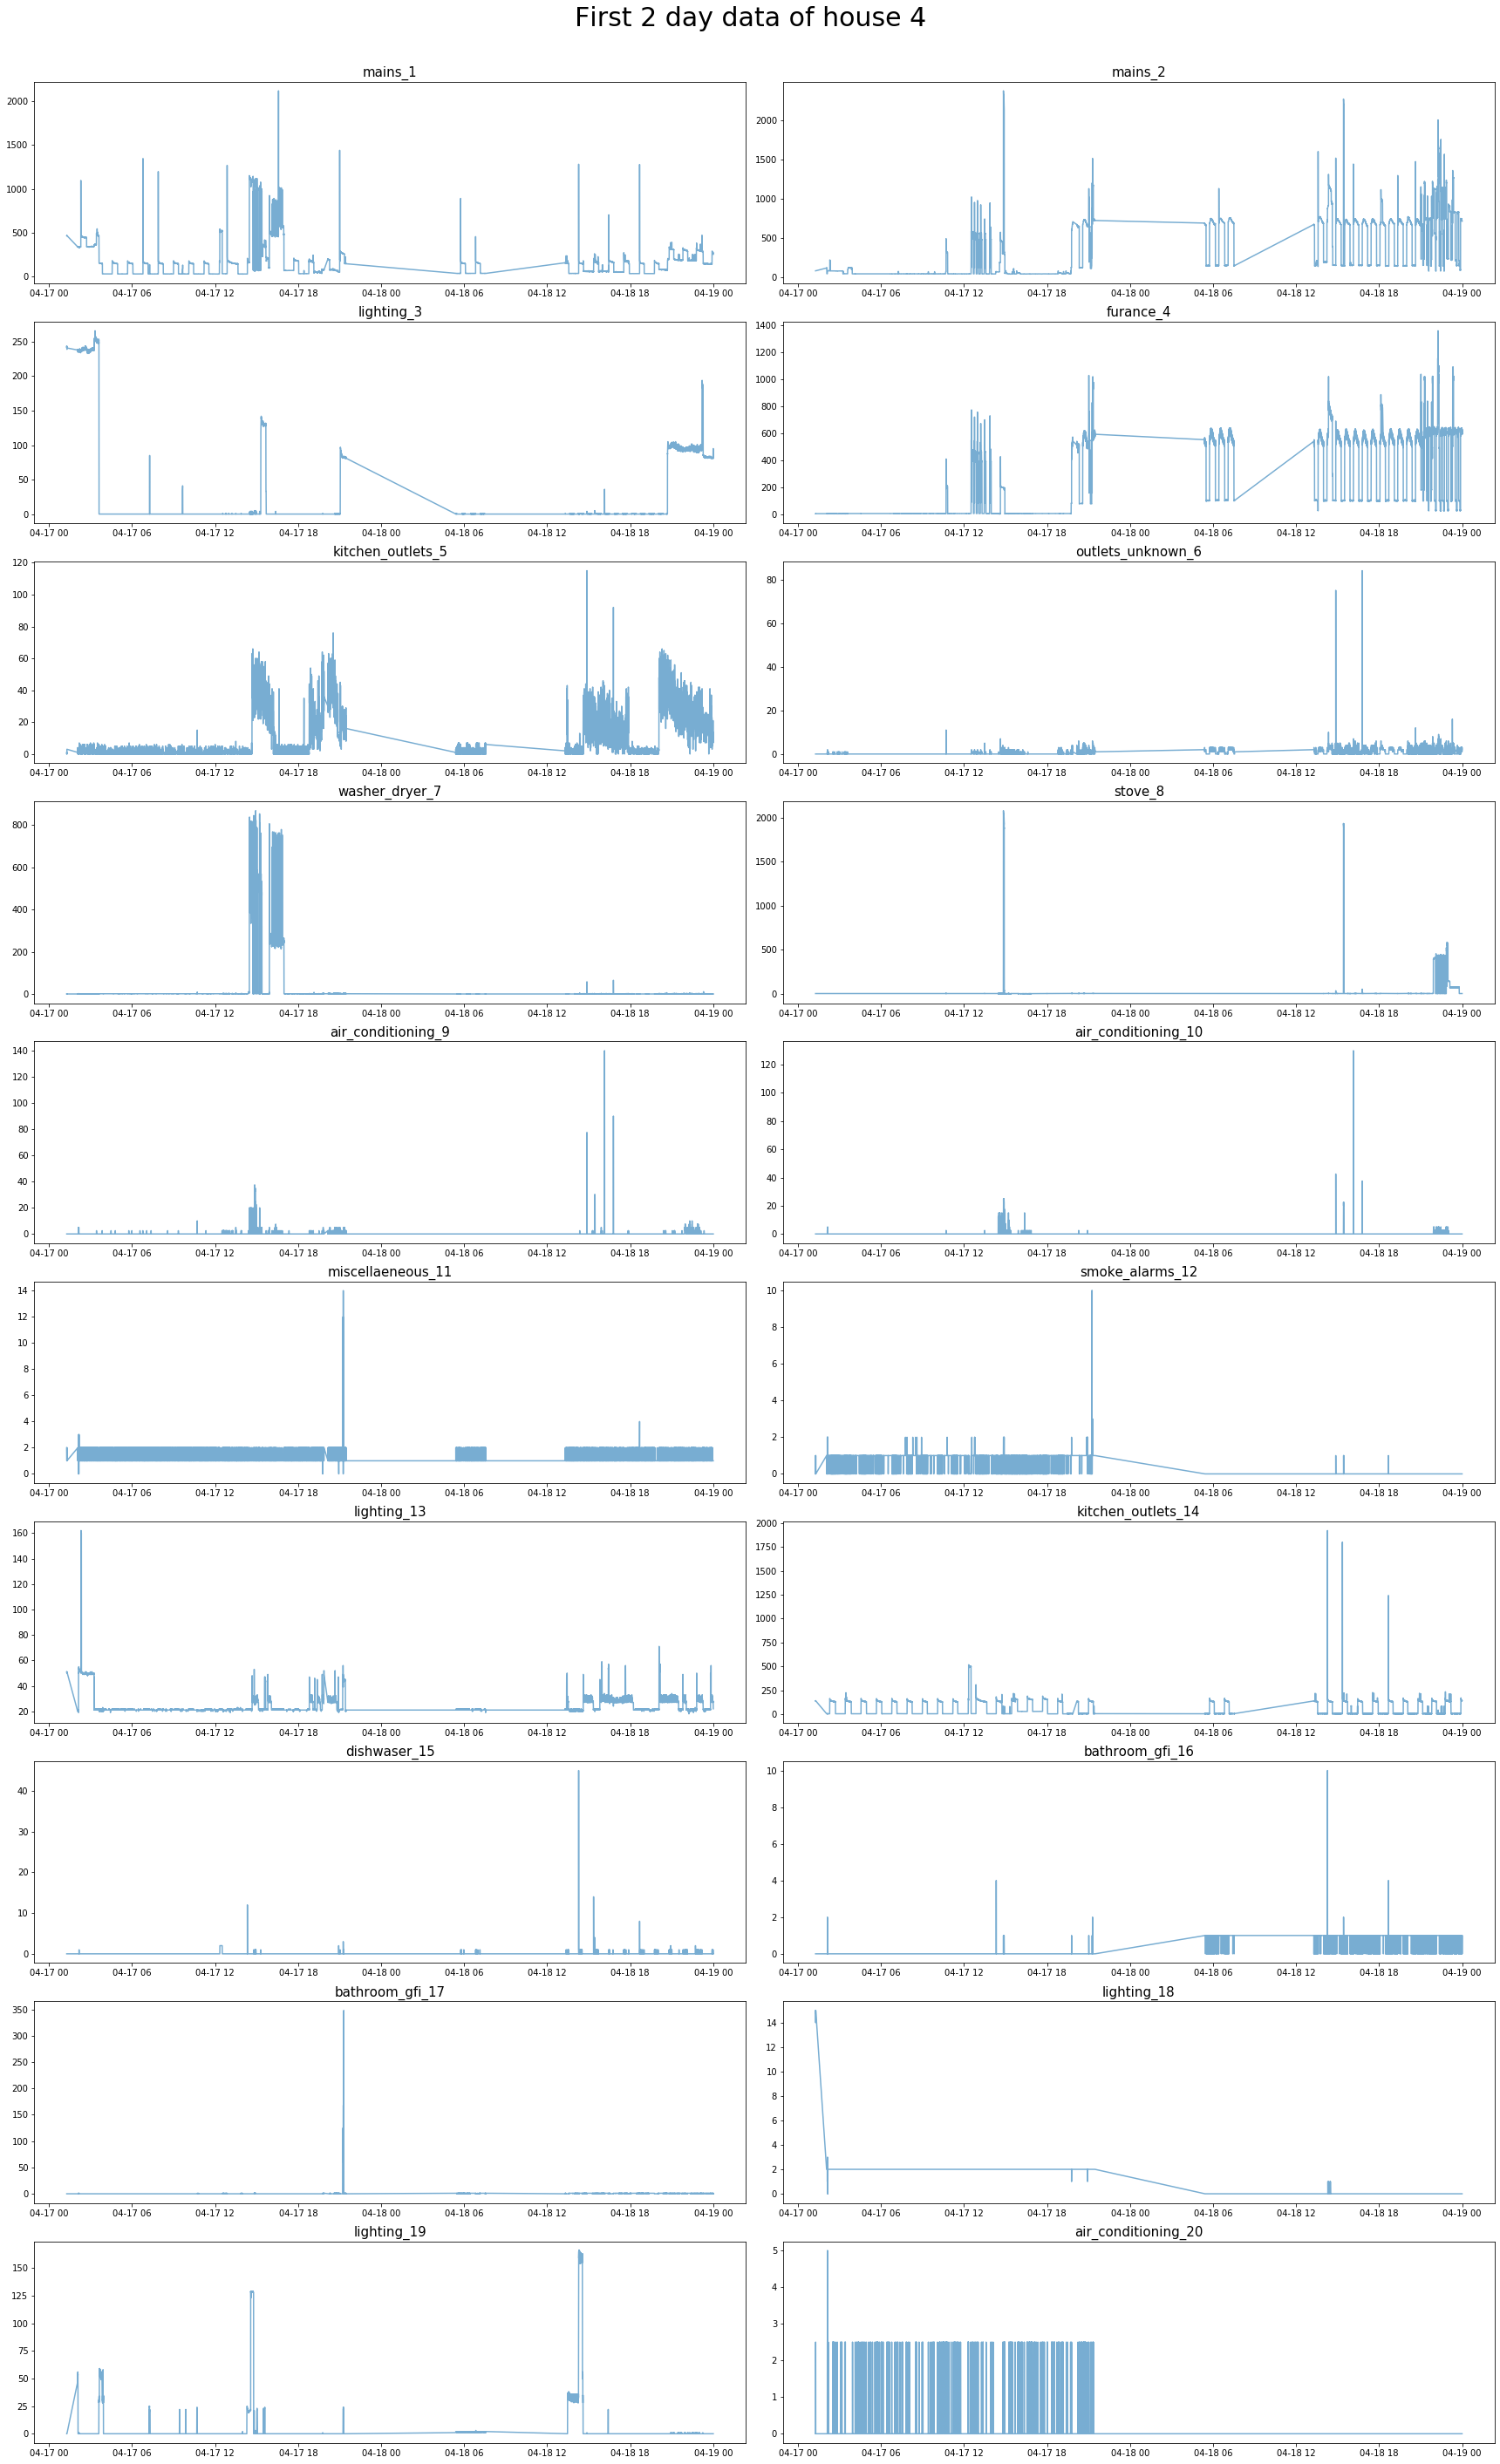

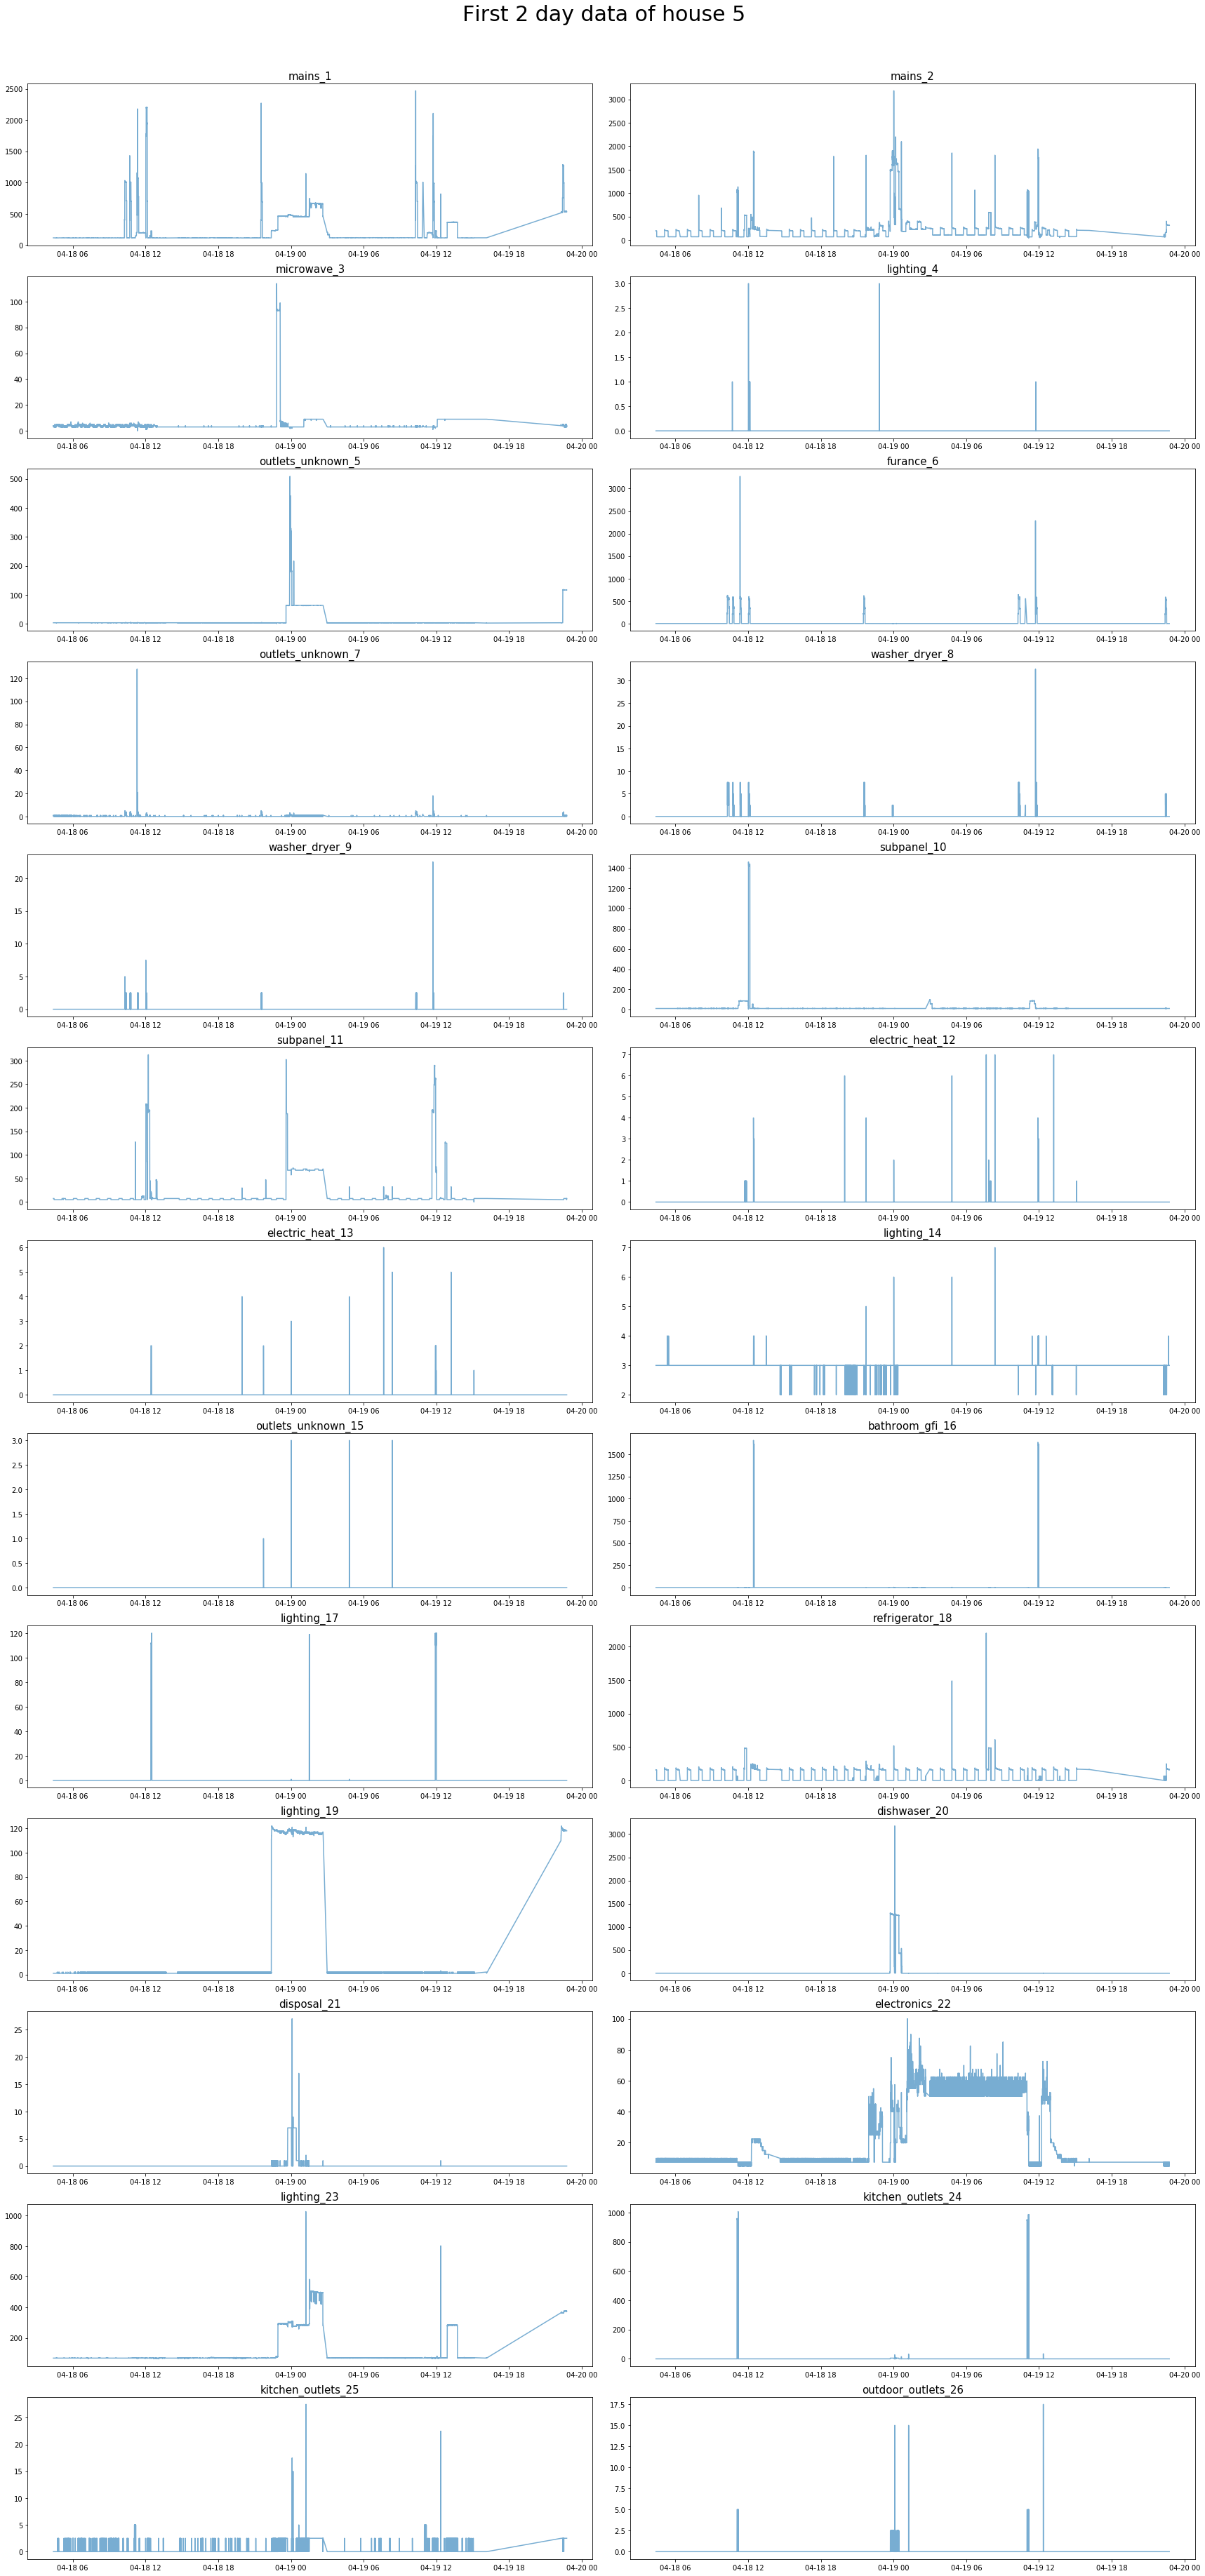

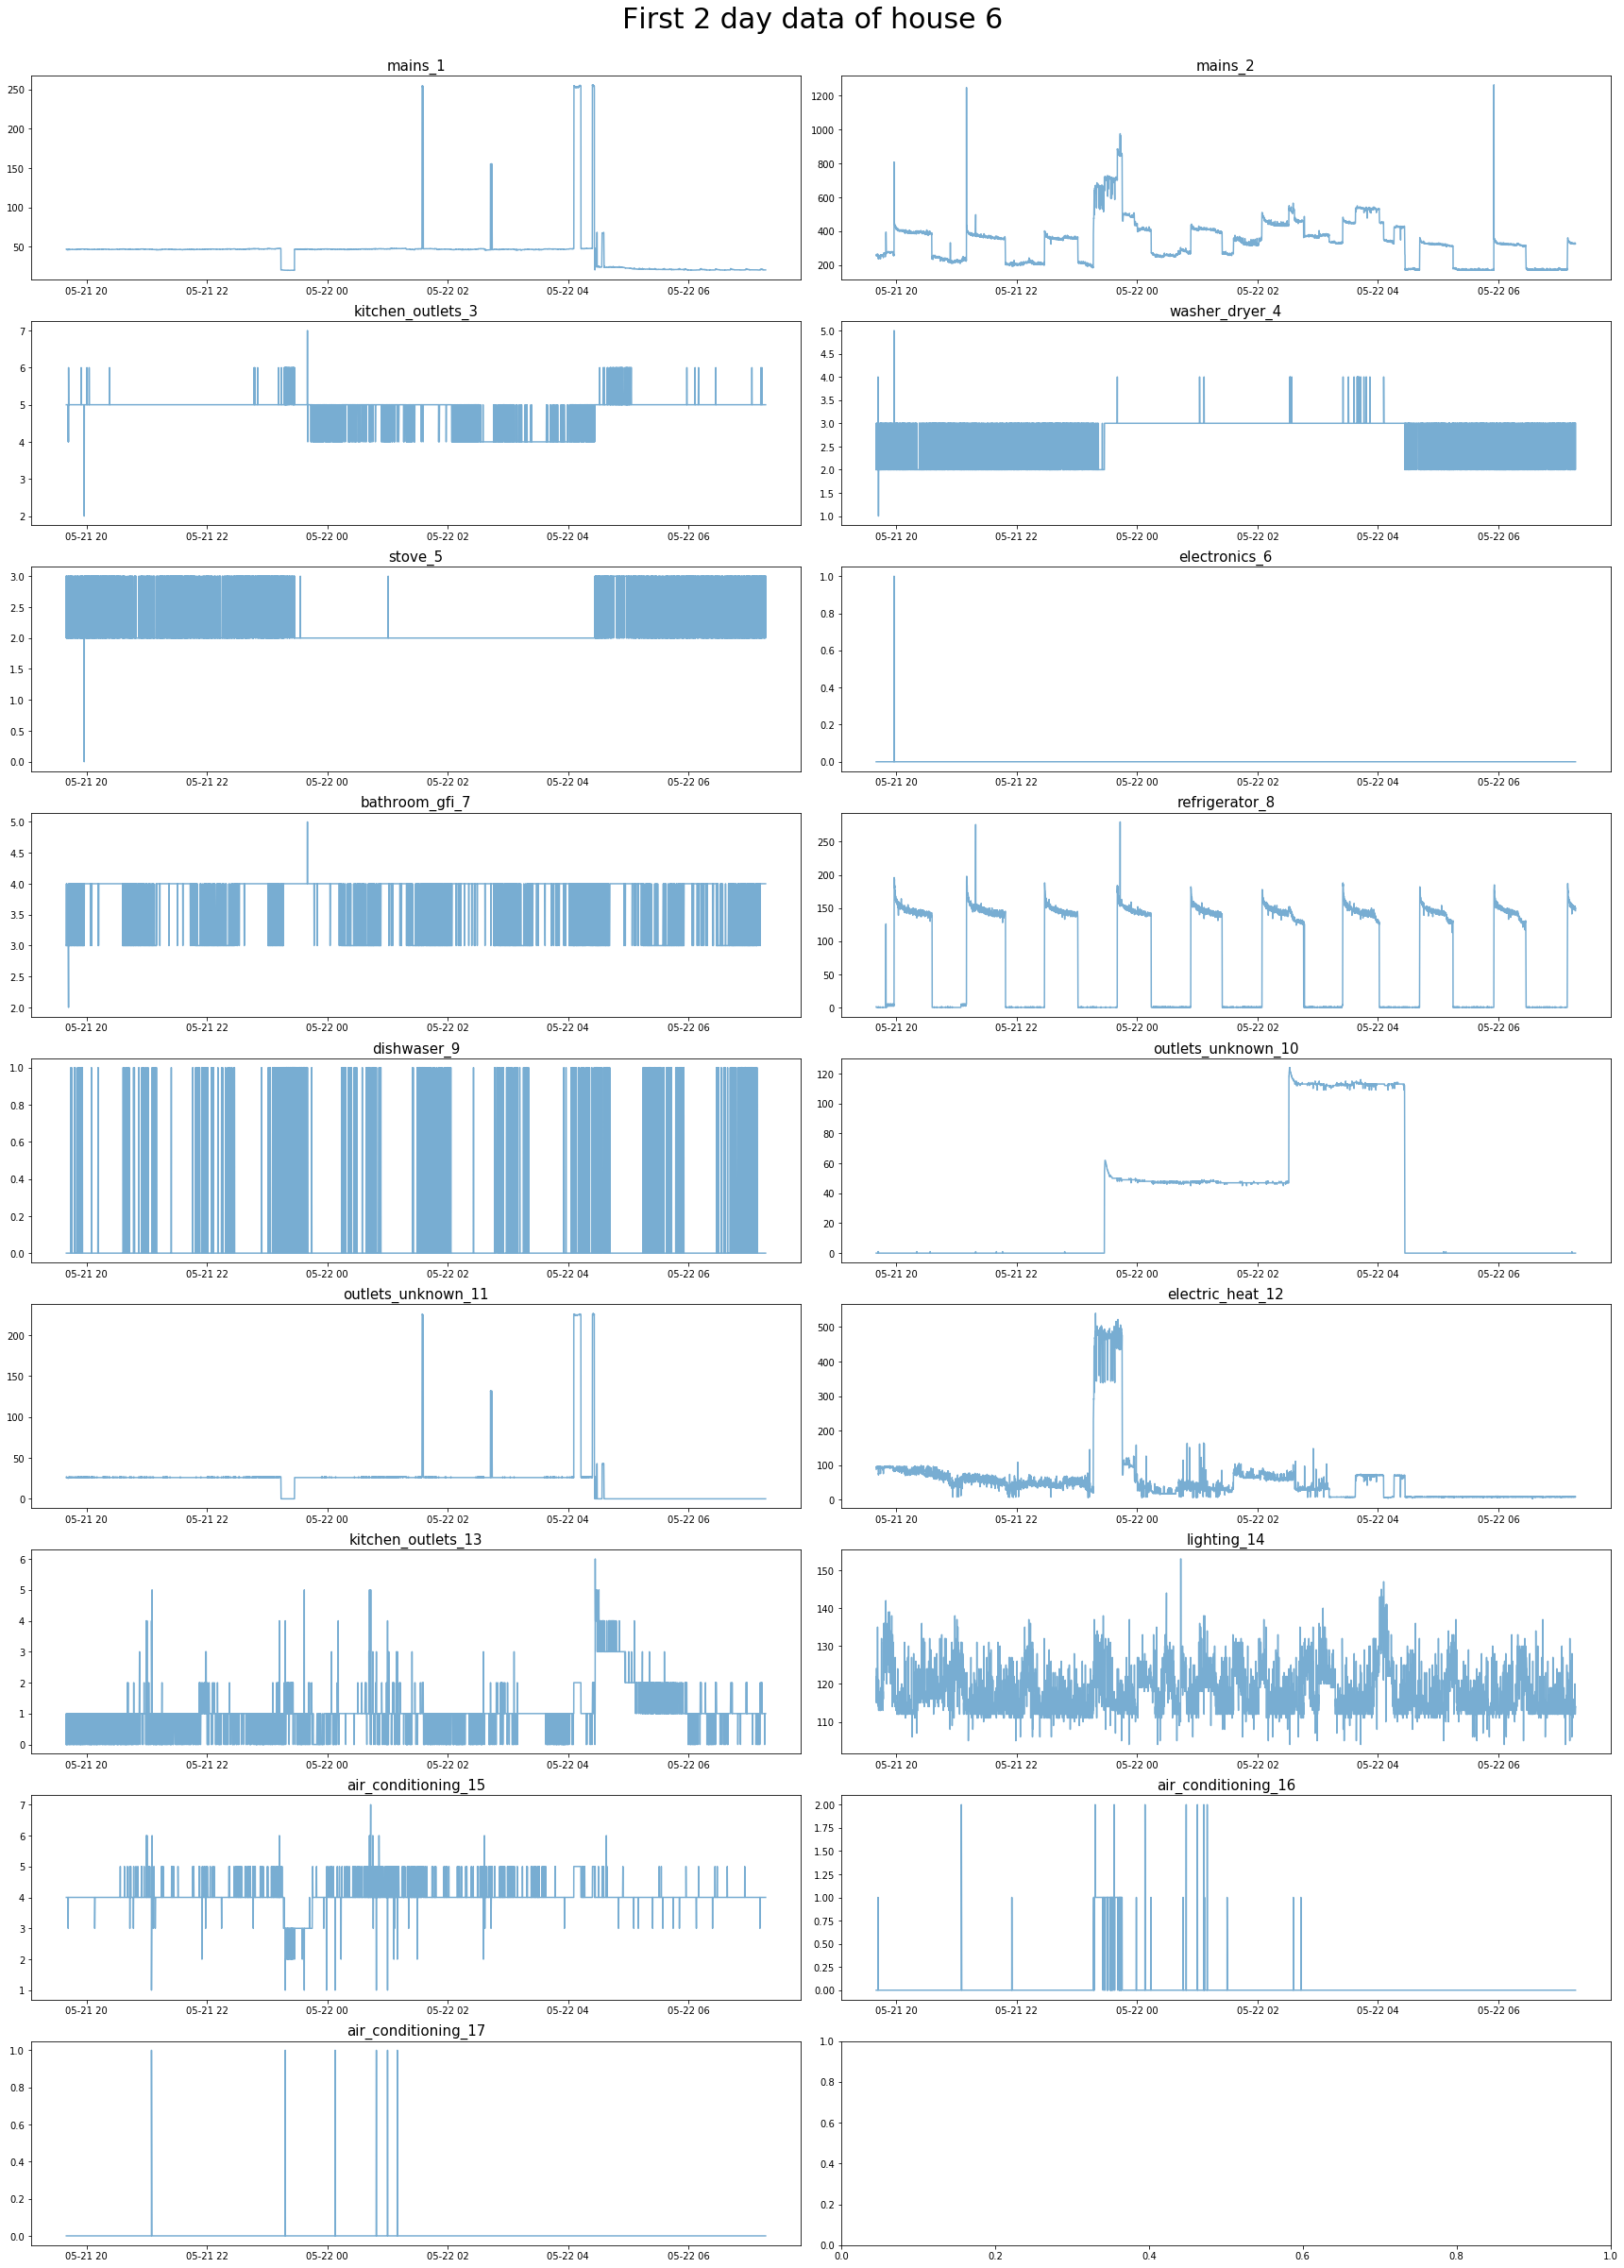

In [16]:
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,7):
    plot_df(df[i].ix[:dates[i][1]], 'First 2 day data of house {}'.format(i))


Text(0.5, 1.0, 'House 2')

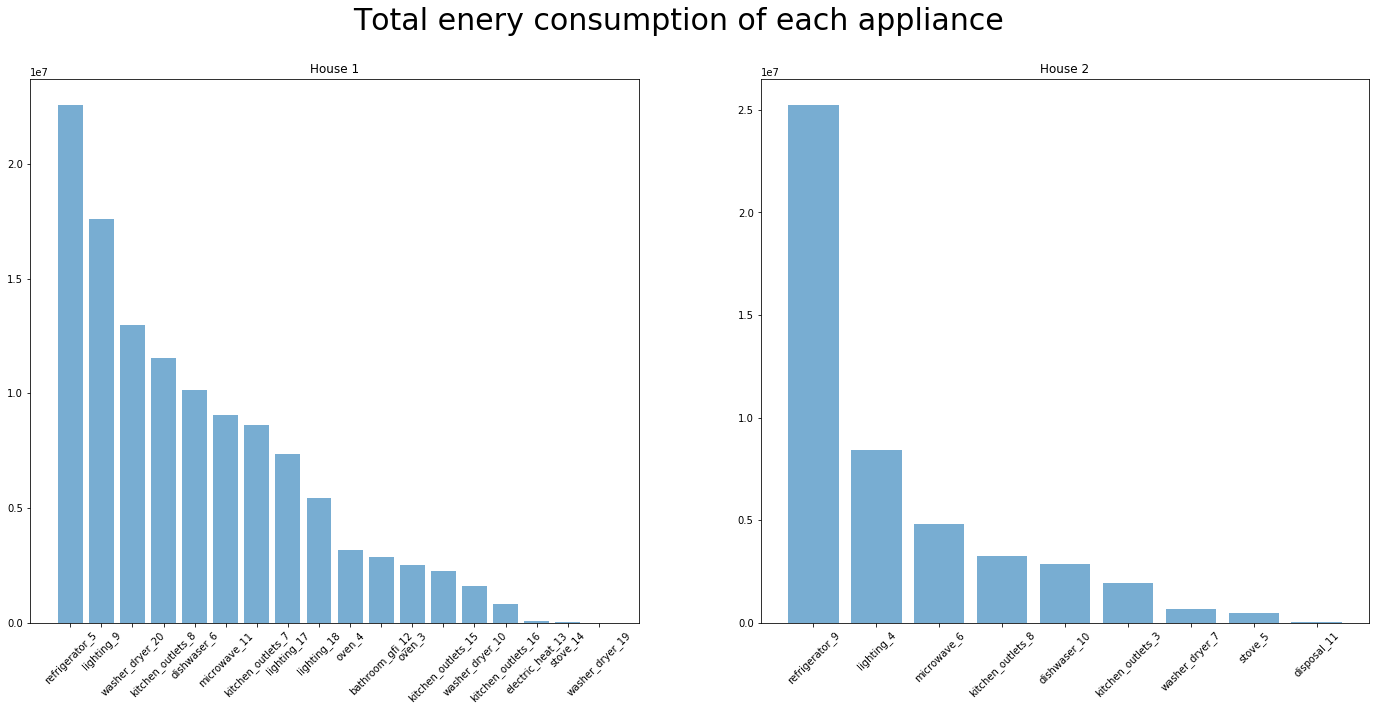

In [6]:
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

## **Running KNN Classifier**

In [18]:

avg=0
c=0
for i in range(1,len(labels)+1):
    for j in range(5,len(labels[i])+1):
        print(labels[i][j])
        X_train, X_test, y_train, y_test = train_test_split(df[i][['mains_1','mains_2']], df[i][labels[i][j]], test_size=0.2, random_state=123)
        try:
            knn = KNeighborsClassifier(n_neighbors=30)
            knn.fit(X_train,y_train)
            avg+=knn.score(X_test,y_test)*100
            c+=1
            
        except:
            continue
print(" Accuracy on Test Set : {:.2f}%".format(avg/c))

refrigerator_5
dishwaser_6
kitchen_outlets_7
kitchen_outlets_8
lighting_9
washer_dryer_10
microwave_11
bathroom_gfi_12
electric_heat_13
stove_14
kitchen_outlets_15
kitchen_outlets_16
lighting_17
lighting_18
washer_dryer_19
washer_dryer_20
stove_5
microwave_6
washer_dryer_7
kitchen_outlets_8
refrigerator_9
dishwaser_10
disposal_11
lighting_5
electronics_6
refrigerator_7
disposal_8
dishwaser_9
furance_10
lighting_11
outlets_unknown_12
washer_dryer_13
washer_dryer_14
lighting_15
microwave_16
lighting_17
smoke_alarms_18
lighting_19
bathroom_gfi_20
kitchen_outlets_21
kitchen_outlets_22
kitchen_outlets_5
outlets_unknown_6
washer_dryer_7
stove_8
air_conditioning_9
air_conditioning_10
miscellaeneous_11
smoke_alarms_12
lighting_13
kitchen_outlets_14
dishwaser_15
bathroom_gfi_16
bathroom_gfi_17
lighting_18
lighting_19
air_conditioning_20
outlets_unknown_5
furance_6
outlets_unknown_7
washer_dryer_8
washer_dryer_9
subpanel_10
subpanel_11
electric_heat_12
electric_heat_13
lighting_14
outlets_unknow